In [1]:
import networkx as nx
import csv
import numpy as np
from collections import Counter
import collections
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import powerlaw as pl
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

plt.rcParams['figure.figsize']=[15,7]

In [2]:
def txt_to_csv(txt_file, skip_lines, comments):
    '''Give txt file, directory to save the file, number(int) of lines to skip and
    what is to be considered as comments.
    Returns csv file.'''
    
    file = np.genfromtxt(txt_file+'.txt', skip_header=skip_lines, comments=comments)

    with open(txt_file + '.csv', 'w') as csvfile:
        for items in file:
            csvfile.write(str(items[0]) + "," 
                      + str(items[1]) + ","
                      + str(items[2]) + "," 
                      + str(items[3]) + ","
                      + str(items[4]) + "," 
                      + str(items[5]) + ","
                      + str(items[6]) + "," 
                      + str(items[7]) + ","
                      + str(items[8]) + ","
                      + str(items[9]) + "," 
                      + "\n")

In [3]:
def read_graph(file_path):

    g = nx.DiGraph()
    file = open(file_path+'.csv','r')
    
    for line in file:
        split = line.split(',')
        n1 = int(float(split[0].strip()))
        n2 = int(float(split[1].strip()))
        capacity = float(split[2].strip())
        length = float(split[3].strip())
        free_flow_time = float(split[4].strip())
        b = float(split[5].strip())
        power = float(split[6].strip())
        speed_limit = float(split[7].strip())
        toll = float(split[8].strip())
        edge_type = float(split[9].strip())
        
        if n1 not in g.nodes():
            g.add_node(n1, color = 'b', size = 50)
        
        if n2 not in g.nodes():
            g.add_node(n2,color='b', size=50)
        
        g.add_edge(n1,
                   n2,
                   capacity=capacity,
                   length=length, 
                   free_flow_time=free_flow_time,
                   b=b,
                   power=power,
                   speed_limit=speed_limit,
                   toll=toll,
                   edge_type=edge_type)
            
    file.close()
    return g

In [67]:
def read_graph_cap(file_path):

    g = nx.DiGraph()
    file = open(file_path+'.csv','r')
    
    for line in file:
        split = line.split(',')
        n1 = int(float(split[0].strip()))
        n2 = int(float(split[1].strip()))
        c = float(split[2].strip())
        if c == 999999.0:
            capacity = 1309
        else:
            capacity = c

        if n1 not in g.nodes():
            g.add_node(n1, color = 'b', size = 50)
        
        if n2 not in g.nodes():
            g.add_node(n2,color='b', size=50)
        
        g.add_edge(n1,
                   n2,
                   capacity=capacity,)
            
    file.close()
    return g

In [4]:
def create_graph(graph1, graph2):
    new_graph = nx.compose(graph1,graph2)
    return new_graph

In [5]:
def create_big_graph(graph_list):
    
    complete_graph = nx.DiGraph()
    
    for graph in graph_list:
        complete_graph = create_graph(graph,complete_graph)
    
    return complete_graph

## Full data

In [52]:
berlin_center_dg = read_graph("./RoadsData/berlin-center_net")
mitte_center_dg = read_graph("./RoadsData/berlin-mitte-center_net")
mitte_friedrichshain_dg = read_graph("./RoadsData/berlin-mitte-prenzlauerberg-friedrichshain-center_net")
prenzlauerberg_dg = read_graph("./RoadsData/berlin-prenzlauerberg-center_net")
tiergarten_dg = read_graph("./RoadsData/berlin-tiergarten_net")
friedrichshain_center_dg = read_graph("./RoadsData/friedrichshain-center_net")

graphs = []
graphs.extend([berlin_center_dg, mitte_center_dg, mitte_friedrichshain_dg, prenzlauerberg_dg, tiergarten_dg, friedrichshain_center_dg])

complete_berlin_dg = create_big_graph(graphs)

len(complete_berlin_dg.edge)
nx.write_edgelist(complete_berlin_dg, 'complete_networld.edgelist')

12981

## Capacity data

In [71]:
berlin_center_dg = read_graph_cap("./RoadsData/berlin-center_net")
mitte_center_dg = read_graph_cap("./RoadsData/berlin-mitte-center_net")
mitte_friedrichshain_dg = read_graph_cap("./RoadsData/berlin-mitte-prenzlauerberg-friedrichshain-center_net")
prenzlauerberg_dg = read_graph_cap("./RoadsData/berlin-prenzlauerberg-center_net")
tiergarten_dg = read_graph_cap("./RoadsData/berlin-tiergarten_net")
friedrichshain_center_dg = read_graph_cap("./RoadsData/friedrichshain-center_net")

graphs = []
graphs.extend([berlin_center_dg, mitte_center_dg, mitte_friedrichshain_dg, prenzlauerberg_dg, tiergarten_dg, friedrichshain_center_dg])

complete_berlin_dg_cap = create_big_graph(graphs)

len(complete_berlin_dg_cap.edge)
nx.write_edgelist(complete_berlin_dg_cap, 'complete_networld_cap.edgelist')

In [22]:
G = nx.read_edgelist("complete_networld.edgelist")

In [23]:
A = nx.to_numpy_matrix(G)

In [24]:
D = np.diagflat(A.sum(axis=1))

In [25]:
L1 = D-A
L2 = nx.laplacian_matrix(G).todense()

In [26]:
print(np.all(L1==L2))

True


In [20]:
def graph_info(G):
    print("# of nodes: %d" % G.number_of_nodes())
    print("# of edges: %d" % G.number_of_edges())
    print("# of selfloops: %d" % G.number_of_selfloops())
    print("Cycle in G:")
    print(nx.find_cycle(G))
    print("G is a DAG: %s" % nx.is_directed_acyclic_graph(G))
    print("G is a tree: %s" % nx.is_tree(G))
    
    print("G's density: %1.2f%%" % (100 * nx.density(G))) #density = number_of_edges / max_theoretical_number_of_edges
    print("G's reciprocity: %1.2f%%" % (100 * nx.reciprocity(G))) #Reciprocity: share of connections going both ways in directed graph
    print("G's clustering coefficient = %s" % nx.transitivity(G))
    print("G is a strongly connected graph: %s" % nx.is_strongly_connected(G))
    print("G is a weakly connected graph: %s" % nx.is_weakly_connected(G))
    
    max_weakly_cc = max(nx.weakly_connected_components(G), key=len)
    min_weakly_cc = min(nx.weakly_connected_components(G), key=len)
    number_weakly_cc = [len(c) for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]
    
    print("Biggest weakly connected component: %s" % max_weakly_cc)
    print("Smallest weakly connected component: %s" % min_weakly_cc)
    print("# of nodes in the connected components in {0}: {1}".format("G",number_weakly_cc))

In [19]:
graph_info(prenzlauerberg_dg)

# of nodes: 352
# of edges: 749
# of selfloops: 0
Cycle in G:
[(1, 296), (296, 1)]
G is a DAG: False
G is a tree: False
G's density: 0.61%
G's reciprocity: 52.07%
G's clustering coefficient = 0.2110236220472441
G is a strongly connected graph: False
G is a weakly connected graph: False
Biggest weakly connected component: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,

In [20]:
def degree_analysis(G):
    degree = nx.degree(G)
    degree_count = Counter(dict(degree).values())
    degree_df = pd.DataFrame(list(degree_count.items()), columns = ('k', 'count'))
    degree_df = degree_df.sort_values(by='k')
    degree_df['p(k)'] = degree_df['count']/degree_df['count'].sum()
    degree_df['log_k']= np.log10(degree_df['k'])
    degree_df['log_p(k)']= np.log10(degree_df['p(k)'])
    print(degree_df.head())
    
    plt.clf()
    plt.subplot(1,2,1)
    plt.title('Linear Scale')
    plt.scatter(degree_df['k'], degree_df['p(k)'])


    plt.subplot(1,2,2)
    plt.title('Logarithmic Scale')
    plt.scatter(degree_df['log_k'], degree_df['log_p(k)']) #Have a thoughtfull look at the x labels (these are powers [2 means 10^2, 3 means 10^3])
    #another way to plot in the log_log scale without calculating the logs is to do the following
    #plt.loglog(degree_df['k'], degree_df['p(k)'])
    plt.show()
    
    degree_df = degree_df.sort_values(by='k', ascending=False)
    degree_df['comsum_p(k)'] = degree_df['p(k)'].cumsum()
    degree_df['log_comsum_p(k)'] = np.log10(degree_df['comsum_p(k)'])
    print(degree_df.head())
    
    plt.clf()
    plt.subplot(1,2,1)
    plt.title("Linear Scale")
    plt.scatter(degree_df['k'], degree_df['comsum_p(k)'])

    plt.subplot(1,2,2)
    plt.title("Logarithmic Scale")
    plt.scatter(degree_df['log_k'],degree_df['log_comsum_p(k)'])
    #try also
    #plt.loglog(degree_df['k'], degree_df['comsum_p(k)'])
    plt.show()
    
    slope,intercept,r_value,p_value,std_error = linregress(np.log10(degree_df['k']),np.log10(degree_df['comsum_p(k)']))
    print(r_value,p_value)
    
    #Let us plot both our distribtuion and the straight line returned by the linear regression
    plt.clf()
    plt.scatter(degree_df['log_k'],degree_df['log_comsum_p(k)'], label="degree distribution")

    plt.plot(degree_df['log_k'],intercept+slope*degree_df['log_k'], 'r--', label="linear regression fit")
    plt.legend()
    plt.show()

In [21]:
def powerlaw(G):

    degrees= sorted(dict(G.degree()).values())

    results = pl.Fit(degrees, discrete=True)

    #First check whether power_law or expoenential distribution is preferred, then whether power_law or lognormal is preferred
    R, p = results.distribution_compare('power_law', 'exponential') #Here we are checking which of those two functions can be a better fit to our distribtuin ('exponential' vs 'power law')
    print(R, p)
    if (R > 0) and (p < .05): #[This means that the power law assumption is preffered over the exponential, but still we have to do another test to have our final claim]
        R, p = results.distribution_compare('power_law', 'lognormal') #Here we are checking which of those two functions can be a better fit to our distribtuin ('lognormal' vs 'power law')
        print(R, p)
        if p < .05: #This means that result we get is significant (statistically) and we can trust it.
            if R > 0:
                print("Powerlaw hypothesis preferred (p = %1.4f, CDF exponent = %1.4f)" % (p, results.power_law.alpha - 1)) # The CDF's alpha is the PMF's alpha minus one. The powerlaw package gives us the PMF's alpha.
            else:
                print("Lognormal hypothesis preferred (p = %1.4f, mu = %1.4f, sigma = %1.4f)" % (p, results.lognormal.mu, results.lognormal.sigma))
        else: #We can not trust the result, and we are not able to differenciate even if R > 0 
            print("Powerlaw and Lognormal are indistinguishable hypotesis.")
    else:
        print("We cannot rule out an exponential fit. Definitely not a power law.")

        

In [22]:
def degree(GRAPH):
    degree_sequence = sorted([d for n, d in GRAPH.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    Gcc = sorted(nx.weakly_connected_component_subgraphs(GRAPH), key=len, reverse=True)[0]
    pos = nx.spring_layout(GRAPH)
    plt.axis('off')
    nx.draw_networkx_nodes(GRAPH, pos, node_size=20)
    nx.draw_networkx_edges(GRAPH, pos, alpha=0.4)

    plt.show()

In [23]:
def centrality_measures(g):
    deg_cen = nx.degree_centrality(g)
    bet_cen = nx.betweenness_centrality(g)
    close_cen = nx.closeness_centrality(g)
    pagerank_cen = nx.pagerank(g)
    
    pos = nx.spring_layout(g,iterations=100)
    plt.subplot(1,4,1)
    plt.title("Degree")
    nx.draw_networkx(g,
                pos=pos,
                node_size=[size*1000 for size in deg_cen.values()],
                with_labels = False,
                width=0.1)
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.title("Between Centrality")
    nx.draw_networkx(g,
                pos=pos,
                node_size=[size*1000 for size in bet_cen.values()],
                with_labels = False,
                width=0.1)
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.title("Closeness Centrality")
    nx.draw_networkx(g,
                pos=pos,
                node_size=[size*1000 for size in close_cen.values()],
                with_labels = False,
                width=0.1)
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.title("Page Rank")
    nx.draw_networkx(g,
                pos=pos,
                node_size=[size*1000 for size in pagerank_cen.values()],
                with_labels = False,
                width=0.1)


    plt.axis('off')
    plt.show()

In [24]:
def node_cores(g):
    pos = nx.spring_layout(g,iterations=100)
    deg_cen = nx.degree_centrality(g)
    nodes_cores = nx.core_number(g)

    nx.draw_networkx(g,
                pos=pos,
                node_color = 'red',
                node_size = [size*1000 for size in deg_cen.values()],
                with_labels=True,
                width=0.1,
                labels=nodes_cores)
    plt.axis('off')
    plt.show()

In [25]:
def avg_shortests_path_hist(g):
    avg_path_length = []
    for n in g.nodes():
        shortes_paths_lengths = nx.single_source_shortest_path_length(g,n).values()
        #print(shortes_paths_lengths)
        avg_path_length.append(sum(shortes_paths_lengths)/(len(shortes_paths_lengths)))
    plt.clf()
    plt.hist(avg_path_length) #avg degree of separation
    plt.axvline(nx.average_shortest_path_length(g), color='red', linestyle='dashed')
    plt.show()

# Berlin Center Analysis

In [26]:
graph_info(berlin_center_dg)

# of nodes: 12981
# of edges: 28370
# of selfloops: 0
Cycle in G:
[(1, 11000), (11000, 1)]
G is a DAG: False
G is a tree: False
G's density: 0.02%
G's reciprocity: 48.64%
G's clustering coefficient = 0.21585039033673825
G is a strongly connected graph: False
G is a weakly connected graph: True
Biggest weakly connected component: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 1

   k  count      p(k)     log_k  log_p(k)
0  1    114  0.008782  0.000000 -2.056403
1  2   3589  0.276481  0.301030 -0.558335
2  3   1048  0.080733  0.477121 -1.092947
3  4   3974  0.306140  0.602060 -0.514080
4  5    444  0.034204  0.698970 -1.465925


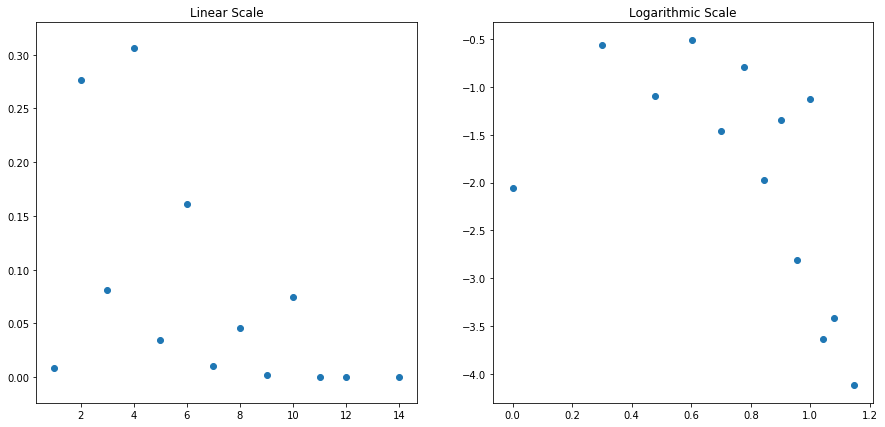

     k  count      p(k)     log_k  log_p(k)  comsum_p(k)  log_comsum_p(k)
12  14      1  0.000077  1.146128 -4.113308     0.000077        -4.113308
11  12      5  0.000385  1.079181 -3.414338     0.000462        -3.335157
10  11      3  0.000231  1.041393 -3.636187     0.000693        -3.159066
9   10    972  0.074879  1.000000 -1.125642     0.075572        -1.121639
8    9     20  0.001541  0.954243 -2.812278     0.077113        -1.112874


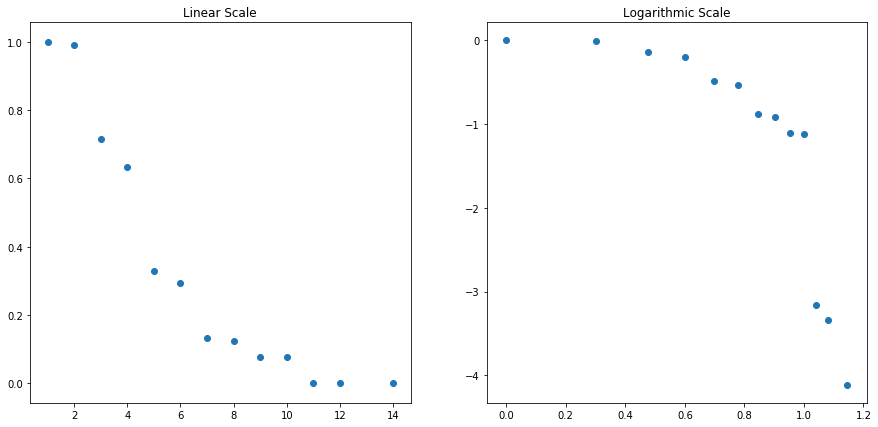

-0.75404543337207 0.0029050403570355277


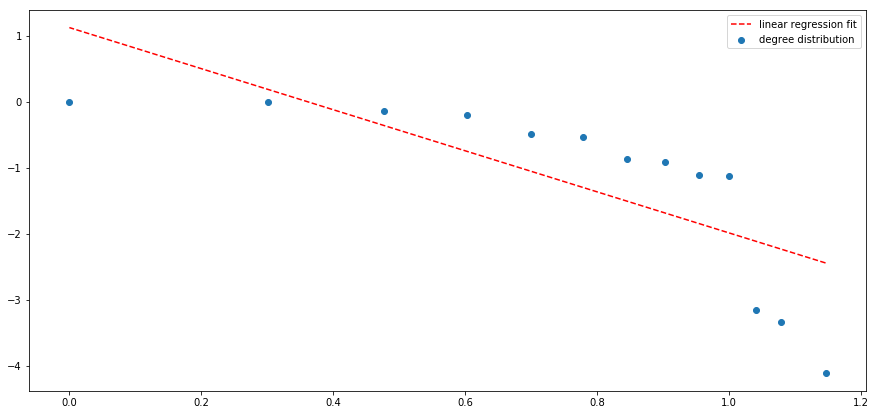

In [197]:
degree_analysis(berlin_center_dg)

In [198]:
powerlaw(berlin_center_dg)

-238.96420429804118 2.927995850082364e-43
We cannot rule out an exponential fit. Definitely not a power law.


Calculating best minimal value for power law fit


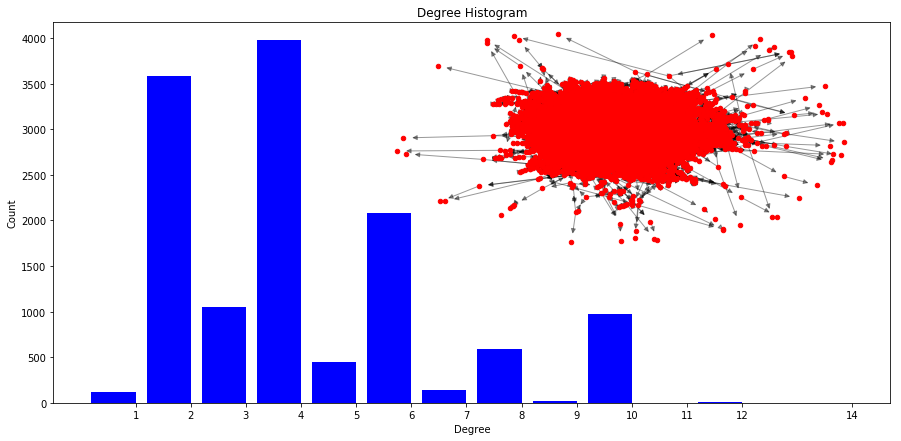

In [143]:
degree(berlin_center_dg)

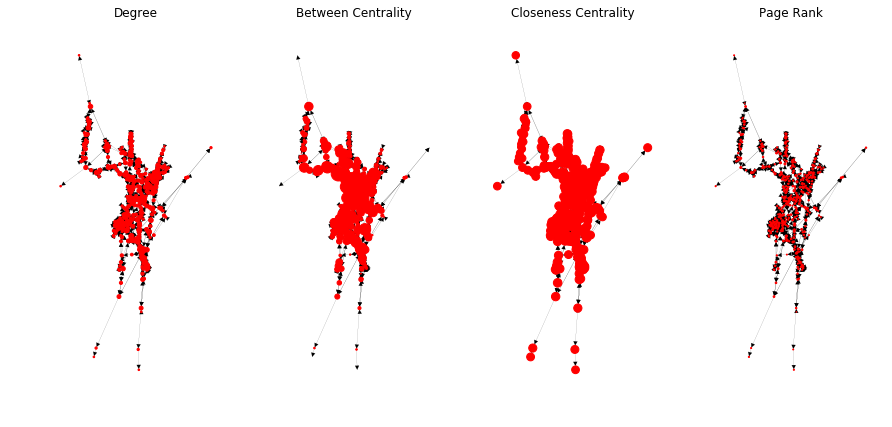

In [152]:
centrality_measures(berlin_center_dg)

In [199]:
node_cores(berlin_center_dg)

KeyboardInterrupt: 

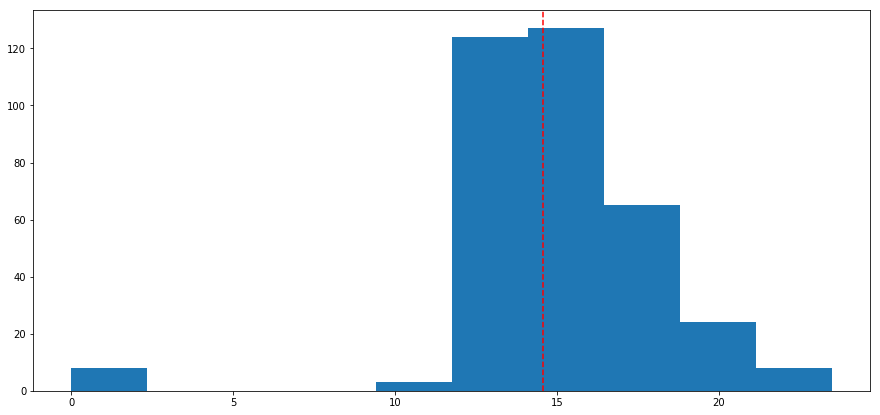

In [160]:
avg_shortests_path_hist(berlin_center_dg)